**Team members:**
Arinn Danish bin Abdullah (SW01081421) &
Muhammad Ahsan Bin Zulfakar (SW01081423)

Import Dataset

In [2]:
import pandas as pd
data = pd.read_csv('/content/Reviews.csv')

Remove duplicated reviews, handle missing data and convert the scores to sentiment categories

In [3]:
# Drop duplicates and handle missing data
data.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], inplace=True)
data.dropna(subset=['Text', 'Score'], inplace=True)

# Convert scores to sentiment categories
data['Sentiment'] = data['Score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')
data = data[data['Sentiment'] != 'neutral']

# Create helpfulness ratio column
data['Helpfulness'] = data['HelpfulnessNumerator'] / data['HelpfulnessDenominator'].replace(0, pd.NA)
data['Helpfulness'].fillna(0, inplace=True)  # Fill NaN values with 0

<ipython-input-3-b582244811ae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Helpfulness'] = data['HelpfulnessNumerator'] / data['HelpfulnessDenominator'].replace(0, pd.NA)


Clean Dataset

In [4]:
import re
from sklearn.preprocessing import MinMaxScaler

def clean_text(text):
    """Remove HTML tags and special characters."""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    return text.lower()

data['Text'] = data['Text'].apply(clean_text)

# Normalize Helpfulness
scaler = MinMaxScaler()
data['Helpfulness'] = scaler.fit_transform(data[['Helpfulness']])


In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Helpfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,i have bought several of the vitality canned d...,positive,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,product arrived labeled as jumbo salted peanut...,negative,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",this is a confection that has been around a fe...,positive,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,if you are looking for the secret ingredient i...,negative,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,great taffy at a great price there was a wide ...,positive,0.0


Comparison graph of each rating

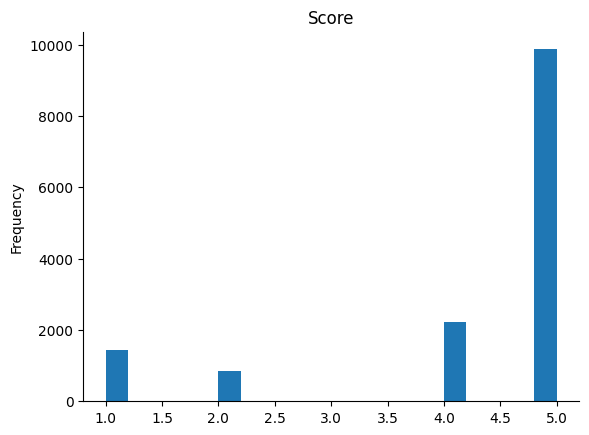

In [11]:
# @title Score

from matplotlib import pyplot as plt
data['Score'].plot(kind='hist', bins=20, title='Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

Comparison graph of positive and negative reviews

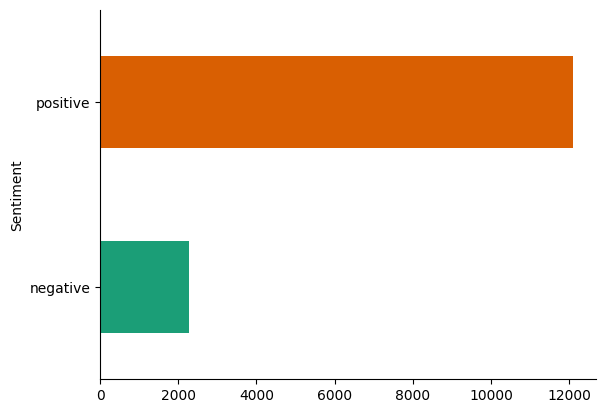

In [8]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Calculate TF-IDF to create machine learning models

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF for Text data
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_features = tfidf_vectorizer.fit_transform(data['Text'])

# Optional: Convert TF-IDF features from sparse matrix to DataFrame if needed for easier handling
tfidf_features_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [13]:
# Combine TF-IDF features with Meta features
# Ensure indices align correctly if combining after text feature extraction
data.reset_index(drop=True, inplace=True)  # Reset index after dropping rows
combined_features = pd.concat([tfidf_features_df, data[['Helpfulness']]], axis=1)

Use VADER library to test the model

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Define a function to get VADER scores
def get_vader_score(text):
    return sid.polarity_scores(text)['compound']

# Apply VADER to the text data
data['Vader_Score'] = data['Text'].apply(get_vader_score)
data['Vader_Predict'] = data['Vader_Score'].apply(lambda x: 'positive' if x > 0 else 'negative')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Use Logistic Regression to train and test the model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Prepare the dataset for training
X = tfidf_features
y = data['Sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

Use Random Forest to train and test the model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Preparing the features and labels
X = combined_features
y = data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


Performance of three different sentiment analysis models

In [18]:
# Evaluating VADER predictions
print("VADER Model Evaluation")
print(classification_report(data['Sentiment'], data['Vader_Predict']))

# Evaluating Logistic Regression predictions
print("Logistic Regression Model Evaluation")
print(classification_report(y_test, log_reg_pred))

# Evaluating Random Forest predictions
print("Random Forest Model Evaluation")
print(classification_report(y_test, predictions))

VADER Model Evaluation
              precision    recall  f1-score   support

    negative       0.62      0.42      0.50      2278
    positive       0.90      0.95      0.92     12086

    accuracy                           0.87     14364
   macro avg       0.76      0.68      0.71     14364
weighted avg       0.85      0.87      0.86     14364

Logistic Regression Model Evaluation
              precision    recall  f1-score   support

    negative       0.89      0.42      0.57       456
    positive       0.90      0.99      0.94      2417

    accuracy                           0.90      2873
   macro avg       0.90      0.71      0.76      2873
weighted avg       0.90      0.90      0.88      2873

Random Forest Model Evaluation
              precision    recall  f1-score   support

    negative       0.94      0.22      0.36       456
    positive       0.87      1.00      0.93      2417

    accuracy                           0.87      2873
   macro avg       0.91      0.61    

In [19]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Helpfulness,Vader_Score,Vader_Predict
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,i have bought several of the vitality canned d...,positive,1.0,0.9441,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,product arrived labeled as jumbo salted peanut...,negative,0.0,-0.5664,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",this is a confection that has been around a fe...,positive,1.0,0.8265,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,if you are looking for the secret ingredient i...,negative,1.0,0.4404,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,great taffy at a great price there was a wide ...,positive,0.0,0.9468,positive


Convert the table to readable CSV file

In [20]:
data.to_csv("/content/updated_reviews.csv", index=False)


**Conclusion**
The Logistic Regression model achieved higher accuracy than the VADER model in classifying sentiment. However, the Random Forest model outperformed both VADER and Logistic Regression in terms of accuracy and F1 scores. This suggests that the Random Forest model captured more complex patterns and relationships in the data compared to the other two models.

Overall, the results of this analysis indicate that the Random Forest model is the most suitable for sentiment classification based on the given dataset. It is important to note that the effectiveness of each model can vary depending on the specific dataset and task at hand. Further improvements could be made by fine-tuning the hyperparameters of the Random Forest model or exploring other advanced techniques such as deep learning.